# Predict Stock Market Trend Using Macro Economical Factors

### Importing libraries

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import tensorflow as tf

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from keras.models import Sequential
from keras.layers import LSTM, Dropout
from keras.layers import Dense

warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = [12, 8]
mpl.rcParams['axes.grid'] = False
sns.set(style="whitegrid", font_scale=1.5)

2023-08-01 08:45:06.448927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Helper Functions

In [2]:
def set_date_index(dataframe, col = "DATE"):
    dataframe[col] = pd.to_datetime(dataframe[col])

In [3]:
def set_to_numeric(dataframe, col):
    dataframe[col] = pd.to_numeric(dataframe[col])

In [4]:
def merge_datasets(features, target):
    for feature in features:
        target = target.merge(feature, how='left', on='DATE')
    return target

### Importing datasets

In [5]:
df_GDP = pd.read_csv('./dataset/GDPC1.csv')
df_UNEMP = pd.read_csv('./dataset/UNEMP.csv')
df_FEDINTRate = pd.read_csv('./dataset/FedFundEffectiveRate.csv')
df_INF = pd.read_csv('./dataset/INFLATION.csv')
df_AAABondYield = pd.read_csv('./dataset/MoodyAaaCorporateBondYield.csv')
df_FEDDebt = pd.read_csv('./dataset/FEDDEBT.csv')
df_3MTBills = pd.read_csv('./dataset/3MTBill.csv')
df_SP500 = pd.read_csv('./dataset/SP500_1.csv')

In [6]:
def load_features():
    global GDP
    GDP = 'GDP'
    global Unemployment_Rate
    Unemployment_Rate = 'UNEMP'
    global FEDInterestRate
    FEDInterestRate = 'FED_Interest_Rate'
    global Inflation
    Inflation = 'INF'
    global Govt_Debt
    Govt_Debt = 'Govt_Debt'
    global Treasury_Bills
    Treasury_Bills = '3M_TBILLS'
    global BondYields
    BondYields = 'BondYields'
    
    df_GDP = pd.read_csv('./dataset/GDPC1.csv')
    df_UNEMP = pd.read_csv('./dataset/UNEMP.csv')
    df_FEDINTRate = pd.read_csv('./dataset/FedFundEffectiveRate.csv')
    df_INF = pd.read_csv('./dataset/INFLATION.csv')
    df_AAABondYield = pd.read_csv('./dataset/MoodyAaaCorporateBondYield.csv')
    df_FEDDebt = pd.read_csv('./dataset/FEDDEBT.csv')
    df_3MTBills = pd.read_csv('./dataset/3MTBill.csv')
    return { GDP : df_GDP, 
            Unemployment_Rate : df_UNEMP, 
            FEDInterestRate : df_FEDINTRate,
            Inflation : df_INF,
            Govt_Debt: df_FEDDebt,
            Treasury_Bills : df_3MTBills,
            BondYields: df_AAABondYield
           }

In [8]:
def prepare_features(features):
    features = [features[GDP], 
                features[Unemployment_Rate], 
                features[Inflation], 
                features[Govt_Debt],
                features[Treasury_Bills], 
                features[BondYields],
                features[Govt_Debt],
                features[Govt_Debt]
                df_AAABondYield, df_FEDDebt, df_3MTBills]
    for df in features:
        set_date_index(df)

SyntaxError: invalid syntax (72656430.py, line 10)

In [9]:
def load_SP500():
    global SP500
    SP500 = 'SP500'
    df_SP500 = pd.read_csv('./dataset/SP500_1.csv')
    df_SP500.rename(columns={'Date' : 'DATE', ' Close': 'Close'}, inplace=True)
    df_SP500.drop(columns=[' Open', ' High', ' Low'], inplace=True)
    set_date_index(df_SP500)
    return df_SP500

In [10]:
features = load_features()

In [11]:
sp_500 = load_SP500()

### Data Pre-Processing 

In [12]:
df_SP500.describe()

,Open,High,Low,Close
count,5930.000000,5930.000000,5930.000000,5930.000000
mean,1928.514442,1940.043705,1916.199410,1928.831295
std,1016.264475,1021.531037,1010.712063,1016.514364
min,675.130000,695.270000,666.790000,676.530000
25%,1188.287500,1195.407500,1180.982500,1188.820000
50%,1447.055000,1456.755000,1436.335000,1447.135000
75%,2469.005000,2477.875000,2460.207500,2471.987500
max,4804.510000,4818.620000,4780.040000,4796.560000


In [13]:
df_SP500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5930 entries, 0 to 5929
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5930 non-null   object 
 1    Open   5930 non-null   float64
 2    High   5930 non-null   float64
 3    Low    5930 non-null   float64
 4    Close  5930 non-null   float64
dtypes: float64(4), object(1)
memory usage: 231.8+ KB


In [14]:
df_SP500.rename(columns={'Date' : 'DATE', ' Close': 'Close'}, inplace=True)
df_SP500.drop(columns=[' Open', ' High', ' Low'], inplace=True)
set_date_index(df_SP500)

In [15]:
df_SP500.describe()

,Close
count,5930.000000
mean,1928.831295
std,1016.514364
min,676.530000
25%,1188.820000
50%,1447.135000
75%,2471.987500
max,4796.560000


###### set date index

In [16]:
features = [df_GDP, df_UNEMP, df_FEDINTRate, df_INF, df_AAABondYield, df_FEDDebt, df_3MTBills]
#setting date column as index index
for df in features:
    set_date_index(df)

In [17]:
#df_AAABondYield
df_AAABondYield['DAAA'].replace(".", method='ffill', inplace=True )
df_AAABondYield.rename(columns={'DAAA' : 'BOND_YIELD'}, inplace=True)
set_to_numeric(df_AAABondYield, 'BOND_YIELD')

In [18]:
#df_INF
df_INF['T10YIE'].replace(".", method='ffill', inplace=True )
df_INF.rename(columns={'T10YIE' : 'INF'}, inplace=True)
set_to_numeric(df_INF, 'INF')

In [19]:
#df_3MonthTBills
df_3MTBills['DTB3'].replace(".", method='ffill', inplace=True )
df_3MTBills.rename(columns={'DTB3' : '3M_TBILLS'}, inplace=True)
set_to_numeric(df_3MTBills, '3M_TBILLS')

In [20]:
#df_gdp
df_GDP.rename(columns={'GDPC1' : 'GDP'}, inplace = True)
set_to_numeric(df_GDP, 'GDP')

In [21]:
#df_unemployment
df_UNEMP.rename(columns={'UNRATE' : 'UNEMP_RATE'}, inplace=True)
set_to_numeric(df_UNEMP, 'UNEMP_RATE')

In [22]:
#df_fedInterestRate
df_FEDINTRate.rename(columns={'DFF' : 'INT_RATE'}, inplace=True)
set_to_numeric(df_FEDINTRate, 'INT_RATE')

In [23]:
#df_fedDebt
df_FEDDebt.rename(columns={'GFDEBTN' : 'GOVT_DEBT'}, inplace=True)
set_to_numeric(df_FEDDebt, 'GOVT_DEBT')

# EDA - Exploring Data

### Merge Datasets

In [24]:
dataset_input = merge_datasets(features, df_SP500)

In [25]:
dataset_input.fillna(method='ffill', inplace=True)

In [26]:
dataset_input.isna().sum()

DATE            0
Close           0
GDP           269
UNEMP_RATE     39
INT_RATE        4
INF             3
BOND_YIELD      4
GOVT_DEBT     269
3M_TBILLS       4
dtype: int64

In [27]:
dataset_input.dropna(inplace=True)

In [28]:
dataset_input.describe()

,Close,GDP,UNEMP_RATE,INT_RATE,INF,BOND_YIELD,GOVT_DEBT,3M_TBILLS
count,5661.000000,5661.000000,5661.000000,5661.000000,5661.000000,5661.000000,5.661000e+03,5661.000000
mean,1828.303310,16390.813809,6.062939,1.616169,2.008467,4.757009,1.522037e+07,1.481203
std,925.935974,1961.268688,2.203219,1.875895,0.414319,1.333459,7.362522e+06,1.730611
min,676.530000,13284.881000,3.500000,0.040000,0.040000,2.010000,5.943439e+06,-0.050000
25%,1178.840000,15161.772000,4.500000,0.130000,1.640000,3.780000,9.229172e+06,0.090000
50%,1418.260000,15876.839000,5.400000,0.990000,2.060000,4.750000,1.479034e+07,0.920000
75%,2186.900000,17724.489000,7.200000,2.310000,2.340000,5.580000,2.197410e+07,2.180000
max,4796.560000,20054.663000,14.700000,7.030000,3.020000,8.120000,3.092891e+07,6.240000


In [29]:
dataset_input

,DATE,Close,GDP,UNEMP_RATE,INT_RATE,INF,BOND_YIELD,GOVT_DEBT,3M_TBILLS
269,2022-07-01,3825.33,20054.663,3.5,1.58,2.34,4.26,30928912.0,1.66
270,2022-06-30,3785.38,20054.663,3.5,1.58,2.33,4.19,30928912.0,1.66
271,2022-06-29,3818.83,20054.663,3.5,1.58,2.36,4.21,30928912.0,1.73
272,2022-06-28,3821.55,20054.663,3.5,1.58,2.48,4.30,30928912.0,1.75
273,2022-06-27,3900.11,20054.663,3.5,1.58,2.55,4.29,30928912.0,1.75
...,...,...,...,...,...,...,...,...,...
5925,2000-01-07,1441.47,13284.881,4.1,5.61,1.64,7.69,5943439.0,5.22
5926,2000-01-06,1403.45,13284.881,4.1,5.54,1.64,7.72,5943439.0,5.25
5927,2000-01-05,1402.11,13284.881,4.1,5.41,1.64,7.78,5943439.0,5.28
5928,2000-01-04,1399.42,13284.881,4.1,5.38,1.64,7.69,5943439.0,5.27


In [30]:
dataset_input.isna().sum()

DATE          0
Close         0
GDP           0
UNEMP_RATE    0
INT_RATE      0
INF           0
BOND_YIELD    0
GOVT_DEBT     0
3M_TBILLS     0
dtype: int64

In [31]:
dataset_input.describe()

,Close,GDP,UNEMP_RATE,INT_RATE,INF,BOND_YIELD,GOVT_DEBT,3M_TBILLS
count,5661.000000,5661.000000,5661.000000,5661.000000,5661.000000,5661.000000,5.661000e+03,5661.000000
mean,1828.303310,16390.813809,6.062939,1.616169,2.008467,4.757009,1.522037e+07,1.481203
std,925.935974,1961.268688,2.203219,1.875895,0.414319,1.333459,7.362522e+06,1.730611
min,676.530000,13284.881000,3.500000,0.040000,0.040000,2.010000,5.943439e+06,-0.050000
25%,1178.840000,15161.772000,4.500000,0.130000,1.640000,3.780000,9.229172e+06,0.090000
50%,1418.260000,15876.839000,5.400000,0.990000,2.060000,4.750000,1.479034e+07,0.920000
75%,2186.900000,17724.489000,7.200000,2.310000,2.340000,5.580000,2.197410e+07,2.180000
max,4796.560000,20054.663000,14.700000,7.030000,3.020000,8.120000,3.092891e+07,6.240000


array([<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>],
      dtype=object)

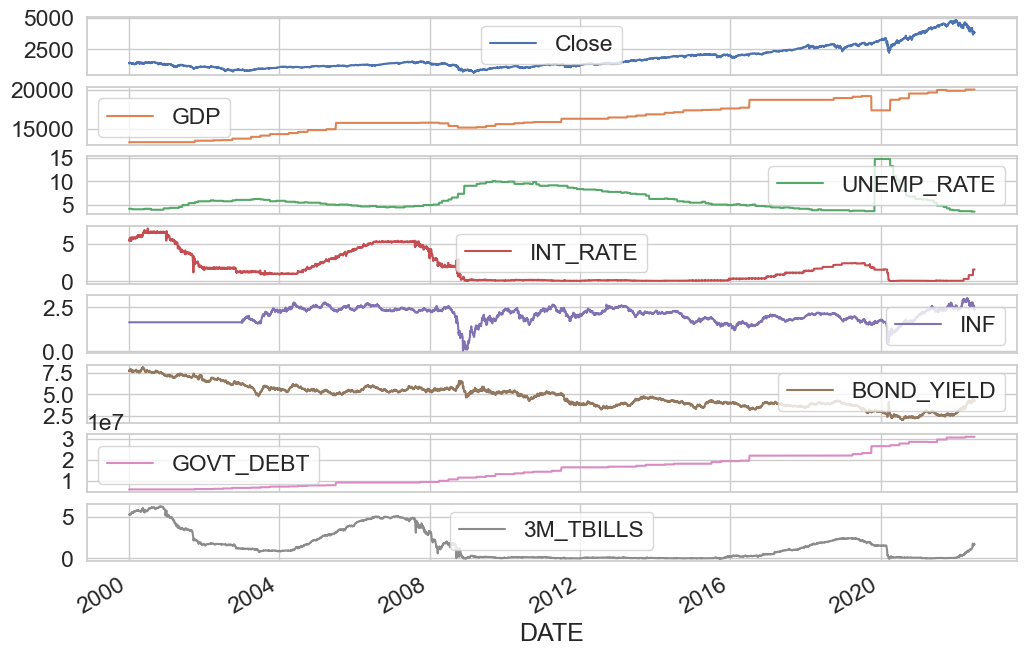

In [32]:
dataset_input.set_index('DATE')[['Close','GDP','UNEMP_RATE','INT_RATE', 'INF', 'BOND_YIELD', 'GOVT_DEBT', '3M_TBILLS']].plot(subplots=True)

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
scaler = MinMaxScaler()

In [35]:
data_scaled = scaler.fit_transform(dataset_input.loc[:, ~dataset_input.columns.isin(['DATE'])])

In [36]:
data_scaled

array([[0.76426628, 1.        , 0.        , ..., 0.36824877, 1.        ,
        0.2718601 ],
       [0.75456975, 1.        , 0.        , ..., 0.35679214, 1.        ,
        0.2718601 ],
       [0.76268862, 1.        , 0.        , ..., 0.36006547, 1.        ,
        0.28298887],
       ...,
       [0.17611037, 0.        , 0.05357143, ..., 0.94435352, 0.        ,
        0.84737679],
       [0.17545746, 0.        , 0.05357143, ..., 0.92962357, 0.        ,
        0.84578696],
       [0.18900105, 0.        , 0.05357143, ..., 0.93944354, 0.        ,
        0.84578696]])

In [89]:
features = data_scaled[:,0:2]
target = data_scaled[:,0]

In [90]:
features

array([[0.76426628, 1.        ],
       [0.75456975, 1.        ],
       [0.76268862, 1.        ],
       ...,
       [0.17611037, 0.        ],
       [0.17545746, 0.        ],
       [0.18900105, 0.        ]])

In [91]:
target

array([0.76426628, 0.75456975, 0.76268862, ..., 0.17611037, 0.17545746,
       0.18900105])

In [92]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123, shuffle=False)

In [93]:
x_train.shape

(4528, 2)

In [94]:
y_train.shape

(4528,)

In [95]:
x_test.shape

(1133, 2)

In [96]:
y_test.shape

(1133,)

In [97]:
win_length = 30
batch_size=32
num_of_features = 2

train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, batch_size=batch_size)
test_generator = TimeseriesGenerator(y_test, y_test, length=win_length, batch_size=batch_size)

In [98]:
train_generator[0]

(array([[[0.76426628, 1.        ],
         [0.75456975, 1.        ],
         [0.76268862, 1.        ],
         ...,
         [0.80029029, 1.        ],
         [0.78272003, 1.        ],
         [0.78258168, 1.        ]],
 
        [[0.75456975, 1.        ],
         [0.76268862, 1.        ],
         [0.76334881, 1.        ],
         ...,
         [0.78272003, 1.        ],
         [0.78258168, 1.        ],
         [0.78813747, 1.        ]],
 
        [[0.76268862, 1.        ],
         [0.76334881, 1.        ],
         [0.78241663, 1.        ],
         ...,
         [0.78258168, 1.        ],
         [0.78813747, 1.        ],
         [0.82822698, 1.        ]],
 
        ...,
 
        [[0.78258168, 1.        ],
         [0.78813747, 1.        ],
         [0.82822698, 1.        ],
         ...,
         [0.90678951, 1.        ],
         [0.9251753 , 1.        ],
         [0.92807091, 1.        ]],
 
        [[0.78813747, 1.        ],
         [0.82822698, 1.        ],
       

In [99]:
train_generator[1]

(array([[[0.80860576, 1.        ],
         [0.8124601 , 1.        ],
         [0.78969085, 1.        ],
         ...,
         [0.92344473, 1.        ],
         [0.93411698, 1.        ],
         [0.94807805, 1.        ]],
 
        [[0.8124601 , 1.        ],
         [0.78969085, 1.        ],
         [0.79092871, 1.        ],
         ...,
         [0.93411698, 1.        ],
         [0.94807805, 1.        ],
         [0.93915093, 0.97645537]],
 
        [[0.78969085, 1.        ],
         [0.79092871, 1.        ],
         [0.80691645, 1.        ],
         ...,
         [0.94807805, 1.        ],
         [0.93915093, 0.97645537],
         [0.93540096, 0.97645537]],
 
        ...,
 
        [[0.94807805, 1.        ],
         [0.93915093, 0.97645537],
         [0.93540096, 0.97645537],
         ...,
         [0.87673391, 0.97645537],
         [0.86139421, 0.97645537],
         [0.88063194, 0.97645537]],
 
        [[0.93915093, 0.97645537],
         [0.93540096, 0.97645537],
       

In [118]:
#model = tf.keras.Sequential()
#model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_of_features), return_sequences=True))
#model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
#model.add(tf.keras.layers.LSTM(128,return_sequences=True))
#model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
#model.add(tf.keras.layers.Dropout(0.3))
#model.add(tf.keras.layers.LSTM(64, return_sequences=False))
#model.add(tf.keras.layers.Dropout(0.3))
#model.add(tf.keras.layers.Dense(1))


model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(win_length, num_of_features), return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 128)               67072     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67,201
Trainable params: 67,201
Non-trainable params: 0
_________________________________________________________________


In [119]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 128)               67072     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67,201
Trainable params: 67,201
Non-trainable params: 0
_________________________________________________________________


In [120]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

In [121]:
model.compile(loss=tf.losses.MeanSquaredError(), 
             optimizer=tf.optimizers.Adam(),
             metrics=[tf.metrics.MeanAbsoluteError()])

In [123]:
history = model.fit_generator(train_generator, epochs=50, validation_data=test_generator, shuffle=False)

Epoch 1/50
140/141 [============================>.] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0618WARNING:tensorflow:Model was constructed with shape (None, 30, 2) for input KerasTensor(type_spec=TensorSpec(shape=(None, 30, 2), dtype=tf.float32, name='lstm_15_input'), name='lstm_15_input', description="created by layer 'lstm_15_input'"), but it was called on an input with incompatible shape (None, None).


ValueError: in user code:

    File "/Users/chandrashekaravula/.pyenv/versions/3.7.16/lib/python3.7/site-packages/keras/engine/training.py", line 1820, in test_function  *
        return step_function(self, iterator)
    File "/Users/chandrashekaravula/.pyenv/versions/3.7.16/lib/python3.7/site-packages/keras/engine/training.py", line 1804, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/chandrashekaravula/.pyenv/versions/3.7.16/lib/python3.7/site-packages/keras/engine/training.py", line 1792, in run_step  **
        outputs = model.test_step(data)
    File "/Users/chandrashekaravula/.pyenv/versions/3.7.16/lib/python3.7/site-packages/keras/engine/training.py", line 1756, in test_step
        y_pred = self(x, training=False)
    File "/Users/chandrashekaravula/.pyenv/versions/3.7.16/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/chandrashekaravula/.pyenv/versions/3.7.16/lib/python3.7/site-packages/keras/engine/input_spec.py", line 233, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer 'sequential_5' (type Sequential).
    
    Input 0 of layer "lstm_15" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, None)
    
    Call arguments received by layer 'sequential_5' (type Sequential):
      • inputs=tf.Tensor(shape=(None, None), dtype=float32)
      • training=False
      • mask=None


In [124]:
train_generator[140]

(array([[[0.10772737, 0.19508959],
         [0.1096594 , 0.19508959],
         [0.10905018, 0.19508959],
         ...,
         [0.09403815, 0.19508959],
         [0.0980988 , 0.19508959],
         [0.10245071, 0.19508959]],
 
        [[0.1096594 , 0.19508959],
         [0.10905018, 0.19508959],
         [0.10858902, 0.19508959],
         ...,
         [0.0980988 , 0.19508959],
         [0.10245071, 0.19508959],
         [0.10270799, 0.19508959]],
 
        [[0.10905018, 0.19508959],
         [0.10858902, 0.19508959],
         [0.10724436, 0.19508959],
         ...,
         [0.10245071, 0.19508959],
         [0.10270799, 0.19508959],
         [0.10439002, 0.19508959]],
 
        ...,
 
        [[0.10185848, 0.19508959],
         [0.1017347 , 0.19508959],
         [0.10238275, 0.19508959],
         ...,
         [0.10312061, 0.19508959],
         [0.10440701, 0.19508959],
         [0.10556719, 0.19508959]],
 
        [[0.1017347 , 0.19508959],
         [0.10238275, 0.19508959],
       

In [71]:
for i in range(len(train_generator)):
    print(train_generator[i])

(array([[0.76426628]]), array([0.75456975]))
(array([[0.75456975]]), array([0.76268862]))
(array([[0.76268862]]), array([0.76334881]))
(array([[0.76334881]]), array([0.78241663]))
(array([[0.78241663]]), array([0.78523943]))
(array([[0.78523943]]), array([0.75708187]))
(array([[0.75708187]]), array([0.7483829]))
(array([[0.7483829]]), array([0.74957221]))
(array([[0.74957221]]), array([0.72773985]))
(array([[0.72773985]]), array([0.72578112]))
(array([[0.72578112]]), array([0.75568867]))
(array([[0.75568867]]), array([0.74245819]))
(array([[0.74245819]]), array([0.74589263]))
(array([[0.74589263]]), array([0.78259867]))
(array([[0.78259867]]), array([0.81098681]))
(array([[0.81098681]]), array([0.83476091]))
(array([[0.83476091]]), array([0.84566132]))
(array([[0.84566132]]), array([0.83613469]))
(array([[0.83613469]]), array([0.83300607]))
(array([[0.83300607]]), array([0.84957877]))
(array([[0.84957877]]), array([0.83123181]))
(array([[0.83123181]]), array([0.83873661]))
(array([[0.8

In [72]:
model.evaluate_generator(test_generator, verbose=1)

1132/1132 [==============================] - 1s 1ms/step - loss: 0.0023 - mean_absolute_error: 0.0385


[0.0023459671065211296, 0.03852273151278496]

In [73]:
predictions = model.predict_generator(test_generator)

In [74]:
predictions.shape[0]

1132

In [75]:
y_train

array([0.76426628, 0.75456975, 0.76268862, ..., 0.10645796, 0.10626622,
       0.10589243])

In [76]:
predictions

array([[0.10077582],
       [0.10077582],
       [0.10077582],
       ...,
       [0.10077582],
       [0.10077582],
       [0.10077582]], dtype=float32)

In [77]:
y_test.shape

(1133,)

In [78]:
x_test

array([0.10499438, 0.10723223, 0.10671767, ..., 0.17611037, 0.17545746,
       0.18900105])

In [79]:
predictions.shape

(1132, 1)

In [82]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test)], axis=1)

In [52]:
df_pred

,0,0,1,2,3,4,5,6
0,0.136801,0.173263,0.187500,0.137339,0.906040,0.662848,0.057458,0.176471
1,0.136895,0.173263,0.187500,0.135908,0.899329,0.666121,0.057458,0.168521
2,0.136992,0.173263,0.187500,0.137339,0.912752,0.661211,0.057458,0.168521
3,0.137109,0.173263,0.187500,0.137339,0.912752,0.672668,0.057458,0.170111
4,0.137228,0.173263,0.187500,0.137339,0.889262,0.666121,0.057458,0.173291
...,...,...,...,...,...,...,...,...
1098,0.020717,0.000000,0.053571,0.796853,0.536913,0.929624,0.000000,0.837838
1099,0.020935,0.000000,0.053571,0.786838,0.536913,0.934534,0.000000,0.842607
1100,0.021123,0.000000,0.053571,0.768240,0.536913,0.944354,0.000000,0.847377
1101,0.021322,0.000000,0.053571,0.763948,0.536913,0.929624,0.000000,0.845787


In [83]:
rev_trans = scaler.inverse_transform(df_pred)

ValueError: operands could not be broadcast together with shapes (1133,2) (8,) (1133,2) 

In [54]:
rev_trans

array([[1.24015541e+03, 1.44578320e+04, 5.60000000e+00, ...,
        6.06000000e+00, 7.37905300e+06, 1.06000000e+00],
       [1.24053948e+03, 1.44578320e+04, 5.60000000e+00, ...,
        6.08000000e+00, 7.37905300e+06, 1.01000000e+00],
       [1.24094038e+03, 1.44578320e+04, 5.60000000e+00, ...,
        6.05000000e+00, 7.37905300e+06, 1.01000000e+00],
       ...,
       [7.63556210e+02, 1.32848810e+04, 4.10000000e+00, ...,
        7.78000000e+00, 5.94343900e+06, 5.28000000e+00],
       [7.64376561e+02, 1.32848810e+04, 4.10000000e+00, ...,
        7.69000000e+00, 5.94343900e+06, 5.27000000e+00],
       [7.65319055e+02, 1.32848810e+04, 4.10000000e+00, ...,
        7.75000000e+00, 5.94343900e+06, 5.27000000e+00]])

In [55]:
df_final = dataset_input[predictions.shape[0]* -1 :]

In [56]:
df_final

,DATE,Close,GDP,UNEMP_RATE,INT_RATE,INF,BOND_YIELD,GOVT_DEBT,3M_TBILLS
4827,2004-05-24,1095.41,14457.832,5.6,1.00,2.74,6.06,7379053.0,1.06
4828,2004-05-21,1093.56,14457.832,5.6,0.99,2.72,6.08,7379053.0,1.01
4829,2004-05-20,1089.19,14457.832,5.6,1.00,2.76,6.05,7379053.0,1.01
4830,2004-05-19,1088.68,14457.832,5.6,1.00,2.76,6.12,7379053.0,1.02
4831,2004-05-18,1091.49,14457.832,5.6,1.00,2.69,6.08,7379053.0,1.04
...,...,...,...,...,...,...,...,...,...
5925,2000-01-07,1441.47,13284.881,4.1,5.61,1.64,7.69,5943439.0,5.22
5926,2000-01-06,1403.45,13284.881,4.1,5.54,1.64,7.72,5943439.0,5.25
5927,2000-01-05,1402.11,13284.881,4.1,5.41,1.64,7.78,5943439.0,5.28
5928,2000-01-04,1399.42,13284.881,4.1,5.38,1.64,7.69,5943439.0,5.27


In [57]:
df_final["Close_Pred"] = rev_trans[:,0]

In [58]:
df_final

,DATE,Close,GDP,UNEMP_RATE,INT_RATE,INF,BOND_YIELD,GOVT_DEBT,3M_TBILLS,Close_Pred
4827,2004-05-24,1095.41,14457.832,5.6,1.00,2.74,6.06,7379053.0,1.06,1240.155409
4828,2004-05-21,1093.56,14457.832,5.6,0.99,2.72,6.08,7379053.0,1.01,1240.539485
4829,2004-05-20,1089.19,14457.832,5.6,1.00,2.76,6.05,7379053.0,1.01,1240.940383
4830,2004-05-19,1088.68,14457.832,5.6,1.00,2.76,6.12,7379053.0,1.02,1241.425082
4831,2004-05-18,1091.49,14457.832,5.6,1.00,2.69,6.08,7379053.0,1.04,1241.913220
...,...,...,...,...,...,...,...,...,...,...
5925,2000-01-07,1441.47,13284.881,4.1,5.61,1.64,7.69,5943439.0,5.22,761.885163
5926,2000-01-06,1403.45,13284.881,4.1,5.54,1.64,7.72,5943439.0,5.25,762.783729
5927,2000-01-05,1402.11,13284.881,4.1,5.41,1.64,7.78,5943439.0,5.28,763.556210
5928,2000-01-04,1399.42,13284.881,4.1,5.38,1.64,7.69,5943439.0,5.27,764.376561


<AxesSubplot:>

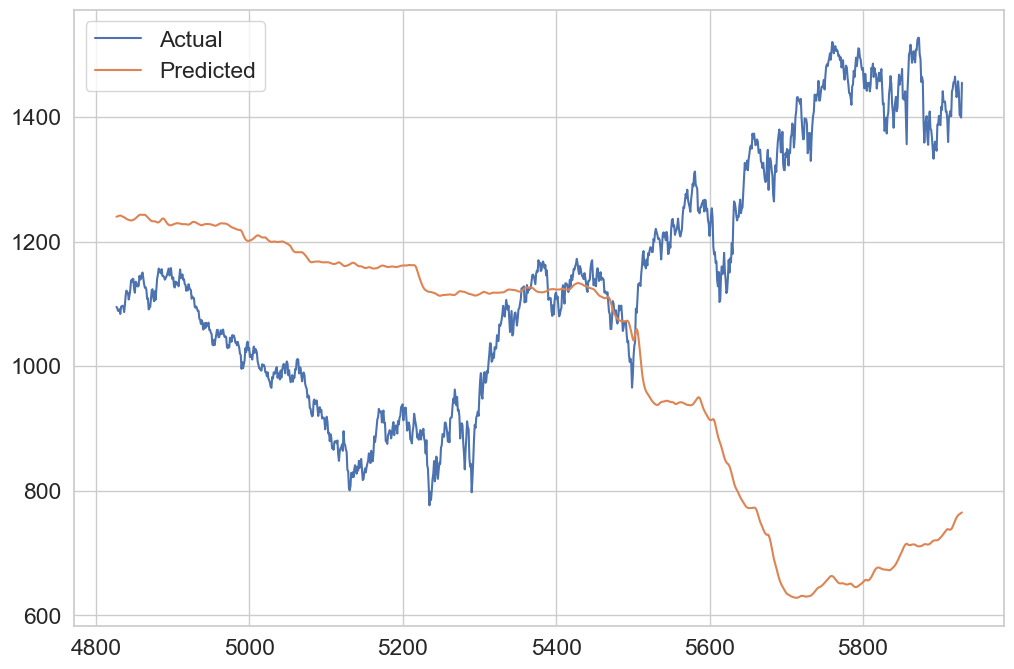

In [59]:

df_final.rename(columns={'Close' : 'Actual', 'Close_Pred': 'Predicted'}, inplace = True)
df_final[['Actual', 'Predicted']].plot()